In [18]:
import pandas as pd
import numpy as np
import datetime

time = datetime.datetime(2024, 4, 20)
ts = int(time.timestamp() * 1000)
date = str.format("{:%Y%m%d}", time)

ts = 1713620244400
ts_end = 1713628344400

path = "/home/niig/Desktop"

In [19]:
def drop_invalid_lines(input_path: str, output_path: str):
    invalid_lines = []

    with open(input_path) as in_file, open(output_path, "w") as out_file:
        for line in in_file:
            if line.startswith("ts"):
                out_file.write(line)
            elif len(line) <= 75:
                if line.startswith("1") and len(line.split(",")[0]) == 13:
                    out_file.write(line)
                else:
                    invalid_lines.append(line)

    df = pd.read_csv(output_path)
    df = df[df.ts > ts]
    df.to_csv(output_path, index=False)
    print(f"Invalid lines count: {len(invalid_lines)}")


def downsample_data(df: pd.DataFrame, period_ms: int = 100):
    df["time"] = pd.to_datetime(df["ts"], unit="ms")
    df = df.drop(columns=["level_1"], errors="ignore")
    df = (
        df.set_index("time")
        .resample(f"{period_ms}ms")
        .mean()
        .dropna(how="all")
        .interpolate()
    )
    df["ts"] = ((df["ts"] / period_ms).round(0) * period_ms).astype("int64")
    df["time"] = pd.to_datetime(df["ts"], unit="ms")
    df = df.set_index("ts").drop_duplicates()
    return df

### Cleanup the GPS file from any invalid lines


In [20]:
input_path = f"{path}/ride_{date}/gps.csv"
output_path = f"{path}/ride_{date}/gps_clean.csv"

drop_invalid_lines(input_path, output_path)

Invalid lines count: 220


### Remove invalid lines from the .


In [21]:
input_path = f"{path}/ride_{date}/measurements.csv"
output_path = f"{path}/ride_{date}/measurements_clean.csv"

drop_invalid_lines(input_path, output_path)

Invalid lines count: 1976


In [22]:
df_gps = pd.read_csv(f"{path}/ride_{date}/gps_clean.csv")
df = pd.read_csv(f"{path}/ride_{date}/measurements_clean.csv")
mapping = {
    0: "heartrate_bpm",
    1: "power_w",
    2: "cadence_rpm",
    3: "speed_kmh",
    4: "distance_km",
    5: "elevation_m",
    6: "ascent",
    7: "descent",
    8: "slope",
    9: "vam",
    10: "air_temperature",
    11: "air_pressure_abs",
    12: "air_humidity",
    13: "air_speed",
    14: "air_density",
    15: "diff_pressure_l_pa",
    16: "diff_pressure_r_pa",
    17: "ax_ms2",
    18: "ay_ms2",
    19: "az_ms2",
    20: "wind_speed",
    21: "wind_yaw",
    22: "gx",
    23: "gy",
    24: "gz",
    25: "mx",
    26: "my",
    27: "mz",
    28: "roll",
    29: "pitch",
    30: "yaw",
}
df["type"] = df["type"].replace(mapping)
df["ts"] = df["ts"].astype("int64", errors="ignore")
df = df[df.ts > ts]
df = df[df.ts < ts_end]


df = (
    df.pivot_table(index="ts", columns=["type"], values=["value"])
    .stack(0)
    .reset_index()
)
df = downsample_data(df)

In [23]:
df_gps = df_gps[df_gps.ts > ts]
df_gps = df_gps[df_gps.ts < ts_end]
df_gps = downsample_data(df_gps)

In [24]:
df = pd.concat([df, df_gps]).sort_index().reset_index()
df = downsample_data(df).reset_index()

In [25]:
df = df[df.ts > ts].round(8)
df = df[df.ts < ts_end]

df.to_csv(f"{path}/ride_{date}/all_measurement_combined_{date}.csv", index=False)

In [26]:
df["ts_d"] = df["ts"].diff()
df[["ts", "ts_d"]].sort_values(by="ts_d", axis=0, ascending=False).head()

,ts,ts_d
30223,1713625442700,7600.0
27820,1713624930000,6100.0
10974,1713621863000,4200.0
44506,1713628116000,4000.0
12908,1713622252200,4000.0


In [27]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth specified in decimal degrees.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def calculate_distance(
    df: pd.DataFrame,
    max_distance_km_beetweeen_measurements: float = 0.1,
    window_size: int = 30,
):
    """
    Calculate the distances between consecutive points in a latitude-longitude time series.
    """
    # Reduce noise from the gps measurements
    df[["lat1", "lon1"]] = df[["lat", "lon"]].rolling(window_size, center=True).mean()
    df[["lat2", "lon2"]] = df[["lat1", "lon1"]].shift(1)
    df["distance"] = haversine(df["lat1"], df["lon1"], df["lat2"], df["lon2"])
    df["distance"] = np.where(
        df["distance"] > max_distance_km_beetweeen_measurements, np.nan, df["distance"]
    )
    df["distance_km"] = df["distance"].cumsum()
    df["distance_m"] = df["distance_km"] * 1000
    return df


def calculate_slope(
    df: pd.DataFrame,
    max_slope_threshold: int = 30,
    window_size: int = 10,
) -> pd.DataFrame:
    """
    Calculate the distances between consecutive points in a latitude-longitude time series.
    """
    df["height_m"] = df["height"] / 100
    df[["height_diff", "distance_diff"]] = (
        df[["height_m", "distance_m"]]
        .interpolate()
        .rolling(window_size, center=True)
        .mean()
        .interpolate()
        .diff()
    )
    df["slope"] = (df.height_diff / df.distance_diff) * 100
    df["slope"] = np.where(df["slope"].abs() > max_slope_threshold, np.nan, df["slope"])
    df["slope"] = df["slope"].interpolate()
    return df


df = calculate_distance(df)
df = calculate_slope(df)
df = df.set_index("distance_km")
df.index.max()
df.columns

Index(['ts', 'air_density', 'air_humidity', 'air_pressure_abs', 'air_speed',
       'air_temperature', 'ax_ms2', 'ay_ms2', 'az_ms2', 'diff_pressure_l_pa',
       'diff_pressure_r_pa', 'elevation_m', 'gx', 'gy', 'gz', 'mx', 'my', 'mz',
       'pitch', 'power_w', 'roll', 'speed_kmh', 'yaw', 'lat', 'lon',
       'satelites', 'hdop', 'vdop', 'has_fix', 'speed', 'distance', 'heading',
       'height', 'time', 'ts_d', 'lat1', 'lon1', 'lat2', 'lon2', 'distance_m',
       'height_m', 'height_diff', 'distance_diff', 'slope'],
      dtype='object')

In [28]:
# measurements are recorded at 10hz, rolling mean is 1 second
window_size = 10

array([<Axes: xlabel='distance_km'>, <Axes: xlabel='distance_km'>,
       <Axes: xlabel='distance_km'>], dtype=object)

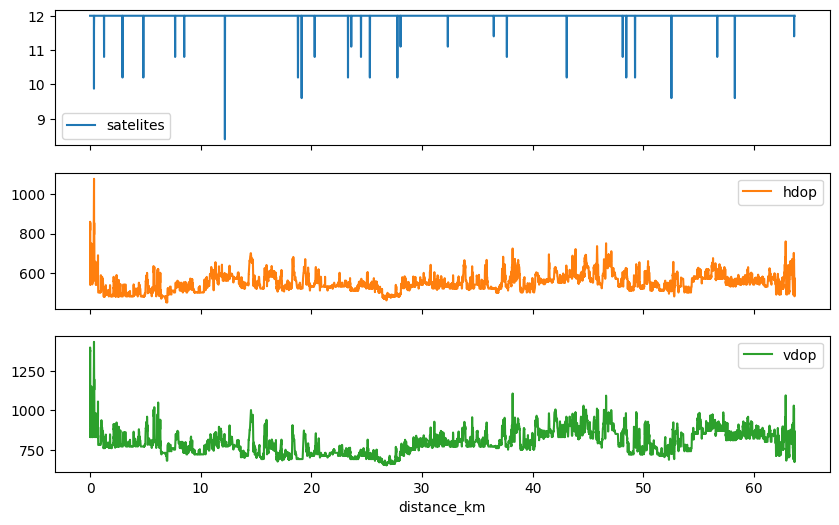

In [29]:
# plot gps stats
df[
    [
        "satelites",
        "hdop",
        "vdop",
    ]
].rolling(
    window_size, center=True
).mean().plot(subplots=True, figsize=(10, 6))

### GPS ride stats


array([<Axes: xlabel='distance_km'>, <Axes: xlabel='distance_km'>,
       <Axes: xlabel='distance_km'>, <Axes: xlabel='distance_km'>],
      dtype=object)

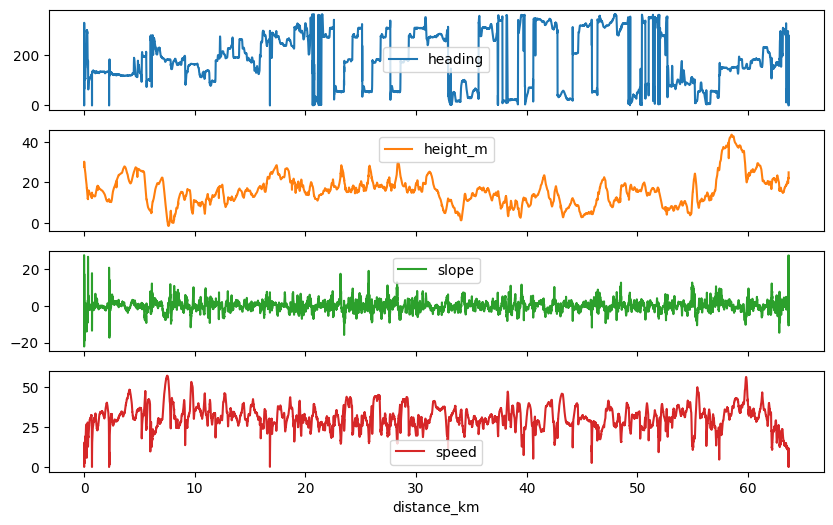

In [30]:
df[
    [
        "heading",
        "height_m",
        "slope",
        "speed",
    ]
].rolling(
    window_size, center=True
).mean().plot(subplots=True, figsize=(10, 6))

array([<Axes: xlabel='distance_km'>, <Axes: xlabel='distance_km'>,
       <Axes: xlabel='distance_km'>, <Axes: xlabel='distance_km'>],
      dtype=object)

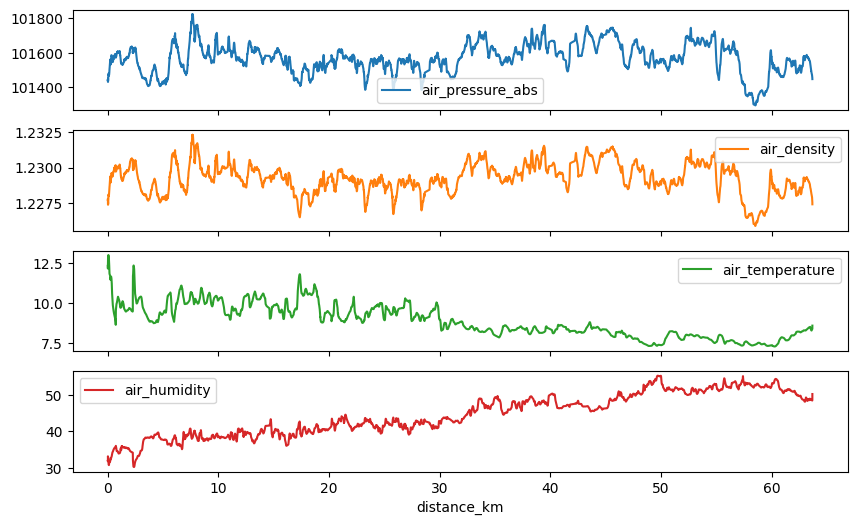

In [31]:
# plot environmental information
df[
    [
        "air_pressure_abs",
        "air_density",
        "air_temperature",
        "air_humidity",
    ]
].rolling(
    window_size, center=True
).mean().plot(subplots=True, figsize=(10, 6))